# I have noticed low test accuracy during and after training Tensorflow LSTM models on  *Apple slicon based Mac* with tensorflow.

# I'll figure out how to resolve this problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout

## Load Dataset

In [2]:
df = pd.read_csv("../DataSets/bitcoin_prices4.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df_chart = df.copy()
df

,timestamp,-1min,price
0,2023-04-08 00:27:00,NaN,27899.05
1,2023-04-08 00:28:00,27899.05,27903.23
2,2023-04-08 00:29:00,27903.23,27906.26
3,2023-04-08 00:30:00,27906.26,27908.45
4,2023-04-08 00:31:00,27908.45,27908.40
...,...,...,...
1996,2023-04-09 09:43:00,27930.57,27932.72
1997,2023-04-09 09:44:00,27932.72,27932.31
1998,2023-04-09 09:45:00,27932.31,27933.48
1999,2023-04-09 09:46:00,27933.48,27932.78


## Dataset Summary

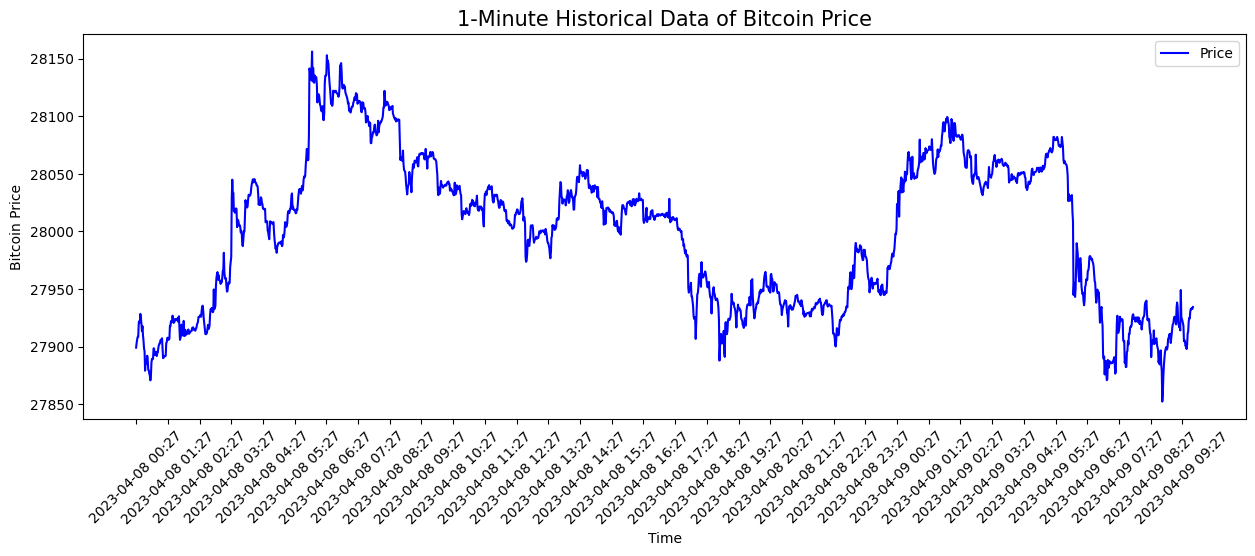

In [3]:
df_chart['timestamp'] = pd.to_datetime(df_chart['timestamp'])
df_chart.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['price'], color='blue', label='Price')
plt.title('1-Minute Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

tick_values = pd.date_range(start=df_chart.index[0], end=df_chart.index[-1], freq='60T')
tick_labels = [date.strftime('%Y-%m-%d %H:%M') for date in tick_values]
plt.xticks(tick_values, tick_labels, rotation=45)

plt.show()

## Set Features and Target

In [4]:
# drop the timestamp column, NaN rows
df = df.drop(df.index[:1])
df.drop(['timestamp'], axis=1, inplace=True)

# split the data into features (X) and target (y)
X = df.drop(['price'], axis=1)

y = df['price']

In [5]:
X

,-1min
1,27899.05
2,27903.23
3,27906.26
4,27908.45
5,27908.40
...,...
1996,27930.57
1997,27932.72
1998,27932.31
1999,27933.48


In [6]:
y

1       27903.23
2       27906.26
3       27908.45
4       27908.40
5       27920.69
          ...   
1996    27932.72
1997    27932.31
1998    27933.48
1999    27932.78
2000    27934.32
Name: price, Length: 2000, dtype: float64

## Split, Scale and Reshape Data

In [7]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

# Reshape the data into 3D array
# Define the number of previous minutes to consider
n_prev_minutes = 60

# Define the number of features in each sample
n_features = X.shape[1]

# Define the number of samples
n_samples = X.shape[0]

# Define the number of time steps
n_time_steps = n_samples - n_prev_minutes

# Create empty arrays for X_3d and y_3d
X_3d = np.zeros((n_time_steps, n_prev_minutes, n_features))
y_1d = np.zeros((n_time_steps,))

# Fill X_3d and y_3d with data from X and y
for i in range(n_time_steps):
    X_3d[i,:,:] = X[i:i+n_prev_minutes,:]
    y_1d[i] = y[i+n_prev_minutes]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_3d, y_1d, test_size=0.3, random_state=42)

## LSTM model

In [8]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_prev_minutes, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Metal device set to: Apple M2


## Summary

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Train

In [10]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50


2023-04-09 06:00:23.910530: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43/43 [==============================] - 7s 84ms/step - loss: 783755264.0000 - accuracy: 0.0000e+00 - val_loss: 783745536.0000 - val_accuracy: 0.0000e+00
Epoch 2/50
43/43 [==============================] - 2s 40ms/step - loss: 783410880.0000 - accuracy: 0.0000e+00 - val_loss: 783566272.0000 - val_accuracy: 0.0000e+00
Epoch 3/50
43/43 [==============================] - 2s 37ms/step - loss: 783255424.0000 - accuracy: 0.0000e+00 - val_loss: 783421952.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
43/43 [==============================] - 2s 38ms/step - loss: 783117824.0000 - accuracy: 0.0000e+00 - val_loss: 783285824.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
43/43 [==============================] - 2s 38ms/step - loss: 782985472.0000 - accuracy: 0.0000e+00 - val_loss: 783153536.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
43/43 [==============================] - 2s 36ms/step - loss: 782856256.0000 - accuracy: 0.0000e+00 - val_loss: 783023360.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
43/43 [===

43/43 [==============================] - 2s 40ms/step - loss: 777488000.0000 - accuracy: 0.0000e+00 - val_loss: 777578816.0000 - val_accuracy: 0.0000e+00


In [11]:
# model.save('model_003.h5')
# loaded_model = keras.models.load_model('model_003.h5')

## Evaluate

In [12]:
y_pred = model.predict(X_test)

19/19 [==============================] - 1s 14ms/step


In [13]:
error_rates = (y_test.values.reshape(-1, 1) - y_pred) / y_test.values.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, average_error_rate, fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
plt.scatter(y_test.index, y_test, color='red', label='Real Price', s=3)
plt.scatter(y_test.index, y_pred, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()